# Linear Implementation

## Required Libraries

First of all, we start by importing our libraries.

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Generator
The first step is to build the generator component.

You will start by creating a function to make a single layer/block for the generator's neural network.

In [2]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_generator_block
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        # Hint: Replace all of the "None" with the appropriate dimensions.
        # The documentation may be useful if you're less familiar with PyTorch:
        # https://pytorch.org/docs/stable/nn.html.
        #### START CODE HERE ####
        nn.Linear(input_dim, output_dim),
        #### END CODE HERE ####
        nn.ReLU(inplace=True)
    )

In [3]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Generator
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            # There is a dropdown with hints if you need them! 
            #### START CODE HERE ####
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
            #### END CODE HERE ####
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

## Noise
We will be creating our noise vector generator function.

In [4]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_noise
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    # NOTE: To use this on GPU with device='cuda', make sure to pass the device 
    # argument to the function you use to generate the noise.
    #### START CODE HERE ####
    return torch.randn((n_samples, z_dim), device=device)
    #### END CODE HERE ####

## Discriminator
The second component that you need to construct is the discriminator. As with the generator component, you will start by creating a function that builds a neural network block for the discriminator.



In [5]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_discriminator_block
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
        #### START CODE HERE ####
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2)
        #### END CODE HERE ####
    )

In [6]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Discriminator
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # Hint: You want to transform the final output into a single value,
            #       so add one more linear map.
            #### START CODE HERE ####
            nn.Linear(hidden_dim, 1)
            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

## Training
Now you can put it all together!
First, you will set your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type, here using a GPU (which runs CUDA), not CPU

Next, you will load the MNIST dataset as tensors using a dataloader.



Here we would specify the cost function, and set our parameters, then we will download our training data.

In [7]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 20
z_dim = 64
display_step = 469
batch_size = 128
lr = 0.00001

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

device = 'cpu'

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Now, you can initialize your generator, discriminator, and optimizers. Note that each optimizer only takes the parameters of one particular model, since we want each optimizer to optimize only one of the models.

In [8]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

## Discriminator loss function

In [9]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_disc_loss
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch (num_images) of fake images. 
    #            Make sure to pass the device argument to the noise.
    #       2) Get the discriminator's prediction of the fake image 
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a 
    #            'ground truth' tensor in order to calculate the loss. 
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!
    #### START CODE HERE ####
    img_noise = get_noise(num_images, z_dim, device=device)
    gen_img = gen(img_noise)
    
    disc_pred_fake = disc(gen_img.detach())
    disc_loss_fake = criterion(disc_pred_fake, torch.zeros_like(disc_pred_fake))
    
    disc_pred_real = disc(real)
    disc_loss_real = criterion(disc_pred_real, torch.ones_like(disc_pred_real))
    
    disc_loss = (disc_loss_fake + disc_loss_real) / 2

    #### END CODE HERE ####
    return disc_loss

## Generator loss function

In [10]:
# UNQ_C7 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gen_loss
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch of fake images. 
    #           Remember to pass the device argument to the get_noise function.
    #       2) Get the discriminator's prediction of the fake image.
    #       3) Calculate the generator's loss. Remember the generator wants
    #          the discriminator to think that its fake images are real
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!

    #### START CODE HERE ####
    img_noise = get_noise(num_images, z_dim, device=device)
    gen_img = gen(img_noise)
    disc_pred = disc(gen_img)
    gen_loss = criterion(disc_pred, torch.ones_like(disc_pred))
    #### END CODE HERE ####
    return gen_loss

## Model Training

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 469: Generator loss: 1.1354996514981242, discriminator loss: 0.4945271927664782


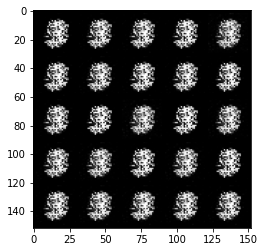

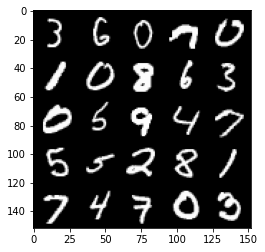

  0%|          | 0/469 [00:00<?, ?it/s]

Step 938: Generator loss: 1.0604467506347686, discriminator loss: 0.557812973825154


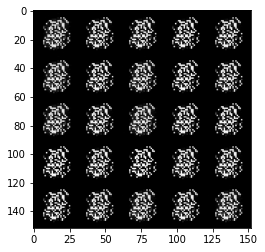

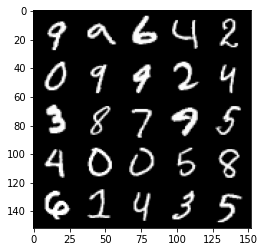

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1407: Generator loss: 1.1138834913910574, discriminator loss: 0.47898876794111506


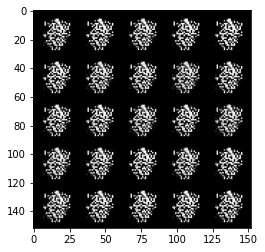

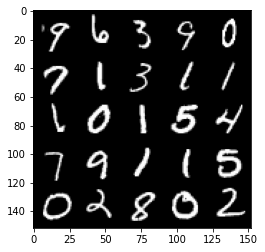

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1876: Generator loss: 1.229195265246353, discriminator loss: 0.4739552984105495


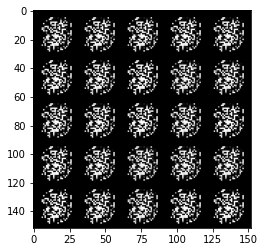

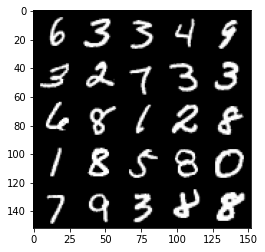

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2345: Generator loss: 1.5209912394663945, discriminator loss: 0.3288807099434867


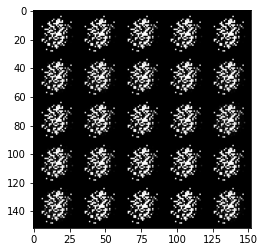

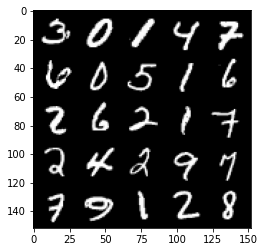

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2814: Generator loss: 1.4162981309362073, discriminator loss: 0.43396292236059714


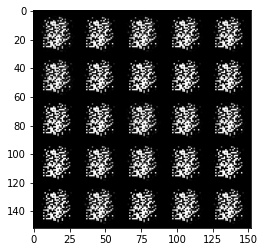

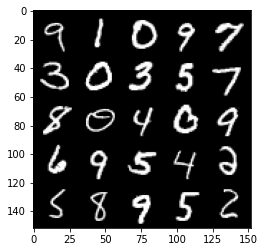

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3283: Generator loss: 1.7130993421652183, discriminator loss: 0.3007946149436139


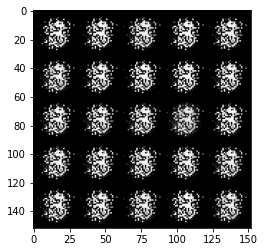

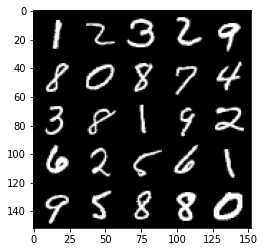

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3752: Generator loss: 1.6858201187048372, discriminator loss: 0.285115697490635


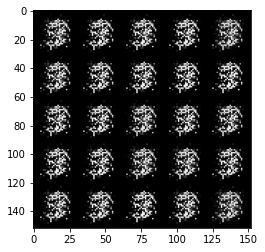

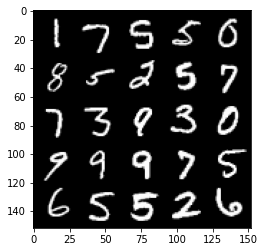

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4221: Generator loss: 1.5751239668840034, discriminator loss: 0.2937042648985438


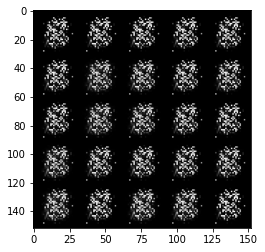

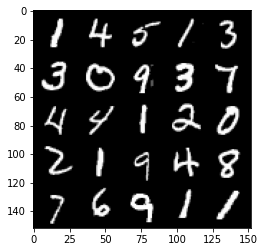

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4690: Generator loss: 1.545082527945546, discriminator loss: 0.28370025023214324


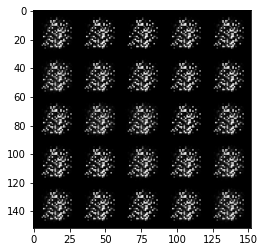

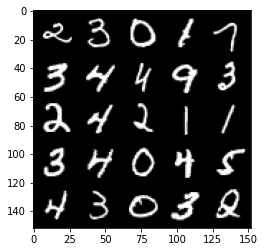

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5159: Generator loss: 1.5783885773311033, discriminator loss: 0.27157564648687194


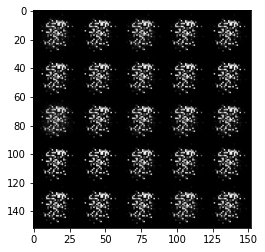

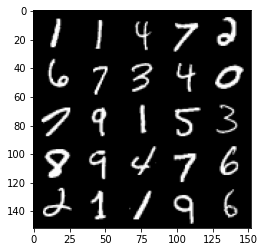

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5628: Generator loss: 1.7943632836535042, discriminator loss: 0.24243452096544596


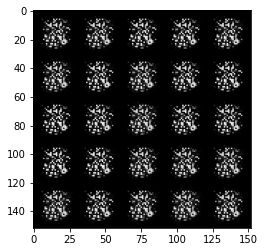

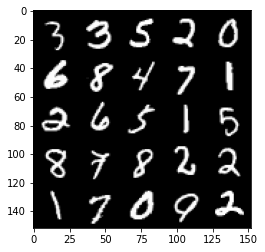

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6097: Generator loss: 2.2258791394833555, discriminator loss: 0.14522191904374027


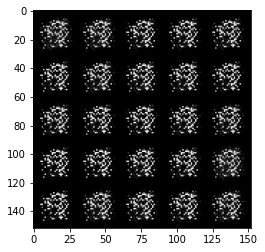

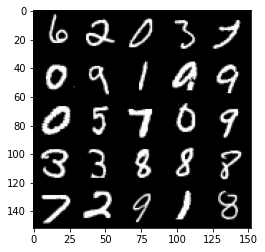

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6566: Generator loss: 2.600978675935821, discriminator loss: 0.10550314000547571


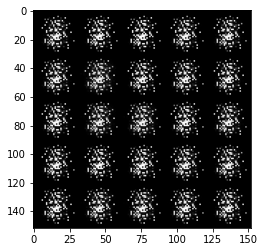

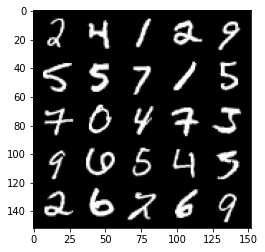

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7035: Generator loss: 2.878120386778416, discriminator loss: 0.08963127257917991


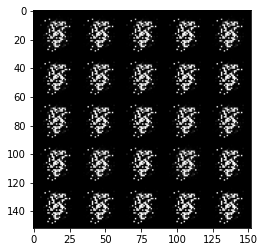

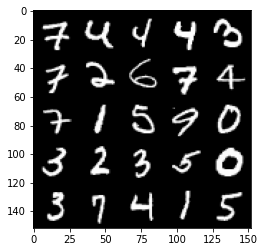

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7504: Generator loss: 3.156740221133365, discriminator loss: 0.07520878421408789


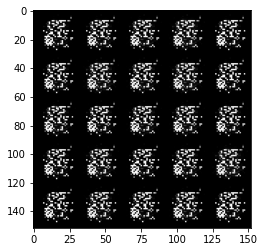

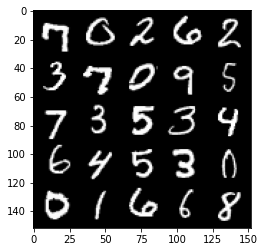

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7973: Generator loss: 3.617541280128301, discriminator loss: 0.04529996593989165


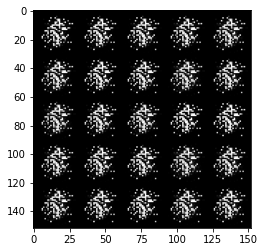

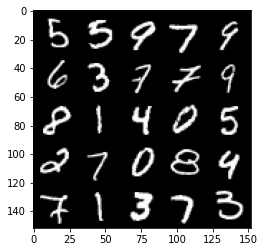

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8442: Generator loss: 3.8637137824792585, discriminator loss: 0.03332029758239675


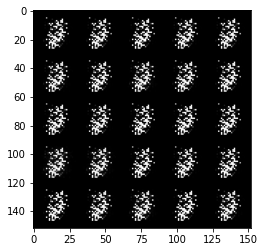

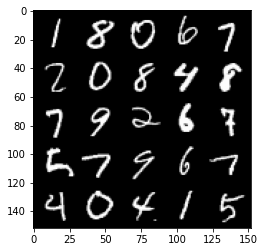

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8911: Generator loss: 3.796807244896639, discriminator loss: 0.03913361157006673


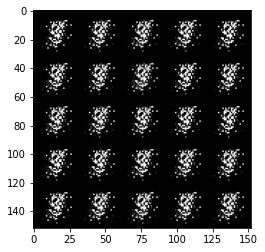

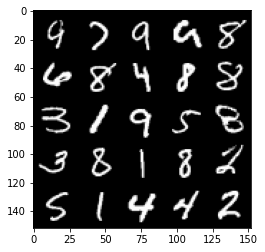

In [11]:
# OPTIONAL PART

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
history = {}
history['Disc_loss'] = []
history['Gen_loss'] = []
real_images= []
fake_images = []
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        history_disc_loss = []
        history_gen_loss = []
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        history_disc_loss.append(disc_loss)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        #     Hint: This code will look a lot like the discriminator updates!
        #     These are the steps you will need to complete:
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        #### START CODE HERE ####
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        history_gen_loss.append(gen_loss)
        gen_loss.backward()
        gen_opt.step()
        #### END CODE HERE ####
        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            real_images.append(real)
            fake_images.append(fake)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
    history['Disc_loss'].append(torch.mean(torch.FloatTensor(history_disc_loss)))
    history['Gen_loss'].append(torch.mean(torch.FloatTensor(history_gen_loss)))


## Plotting Losses

In [12]:
from matplotlib import pyplot as plt

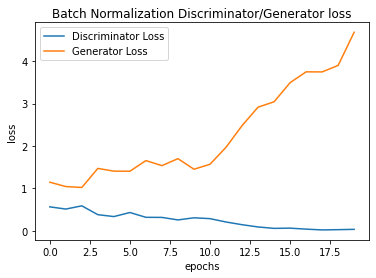

In [13]:
plt.plot(range(len(history['Disc_loss'])), history['Disc_loss'])
plt.plot(range(len(history['Gen_loss'])), history['Gen_loss'])
plt.title('Batch Normalization Discriminator/Generator loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()

Now we will save each epoch's image for more illustration.

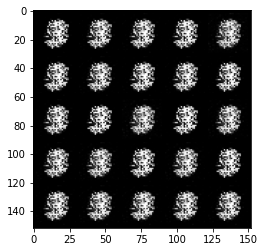

In [14]:
show_tensor_images(fake_images[0])

In [15]:
type(fake_images[0])

torch.Tensor

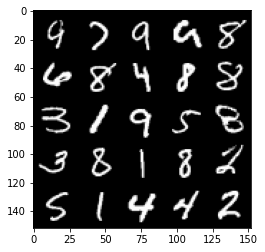

In [18]:
images = []
size=(1, 28, 28)
num_images=25
i = 1
for filename in real_images:
  image_unflat = filename.detach().cpu().view(-1, *size)
  image_grid = make_grid(image_unflat[:num_images], nrow=5)
  image_grid = image_grid.permute(1, 2, 0).squeeze()
  image_grid = image_grid.detach().cpu().numpy()
  plt.imshow(image_grid)
  plt.imsave('outputr/'+str(i)+'.png', image_grid)
  i+=1
  

In [19]:
!zip -r /content/file.zip /content/outputr
from google.colab import files
files.download("/content/file.zip")

  adding: content/outputr/ (stored 0%)
  adding: content/outputr/6.png (deflated 4%)
  adding: content/outputr/8.png (deflated 4%)
  adding: content/outputr/12.png (deflated 4%)
  adding: content/outputr/3.png (deflated 4%)
  adding: content/outputr/15.png (deflated 5%)
  adding: content/outputr/11.png (deflated 4%)
  adding: content/outputr/19.png (deflated 5%)
  adding: content/outputr/2.png (deflated 5%)
  adding: content/outputr/9.png (deflated 4%)
  adding: content/outputr/17.png (deflated 5%)
  adding: content/outputr/5.png (deflated 4%)
  adding: content/outputr/7.png (deflated 5%)
  adding: content/outputr/10.png (deflated 5%)
  adding: content/outputr/1.png (deflated 4%)
  adding: content/outputr/14.png (deflated 4%)
  adding: content/outputr/13.png (deflated 4%)
  adding: content/outputr/16.png (deflated 5%)
  adding: content/outputr/18.png (deflated 5%)
  adding: content/outputr/4.png (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>